<b>Face Generation using Pytorch</b><br>
--
Coded by : Nub-T<br><br>
Here is data <a href="https://www.kaggle.com/jessicali9530/celeba-dataset">link</a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
from PIL import Image
from IPython.display import display
import glob

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
transformObj = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

In [7]:
dataroot = "celeba-dataset/img_align_celeba/"
dataset = datasets.ImageFolder(root=dataroot, transform=transformObj)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_size=100):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l1b = nn.BatchNorm2d(32)
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l2b = nn.BatchNorm2d(64)
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l3b = nn.BatchNorm2d(128)
        self.l4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.l4b = nn.BatchNorm2d(256)
        self.l41 = nn.Linear(256*4*4, self.latent_size)
        self.l42 = nn.Linear(256*4*4, self.latent_size)
        
        self.f = nn.Linear(self.latent_size, 256*4*4)
        
        self.l5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l6 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l7 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l8 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)
        
    def encoder(self, x_in):
        h = F.leaky_relu(self.l1b(self.l1(x_in)))
        h = F.leaky_relu(self.l2b(self.l2(h)))
        h = F.leaky_relu(self.l3b(self.l3(h)))
        h = F.leaky_relu(self.l4b(self.l4(h)))
        h = h.view(h.size(0), -1)
        return self.l41(h), self.l42(h)
    
    def decoder(self, z):
        z = self.f(z)
        z = z.view(-1, 256, 4, 4)
        z = F.leaky_relu(self.l5(z))
        z = F.leaky_relu(self.l6(z))
        z = F.leaky_relu(self.l7(z))
        z = torch.sigmoid(self.l8(z))
        
        return z
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return torch.add(eps.mul(std), mu)
    
    def forward(self, x_in):
        mu, log_var = self.encoder(x_in)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [9]:
vae = VAE()
    
vae.to(device)

VAE(
  (l1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l1b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l3b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l4b): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l41): Linear(in_features=4096, out_features=100, bias=True)
  (l42): Linear(in_features=4096, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=4096, bias=True)
  (l5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2),

In [10]:
optimizer = optim.Adam(vae.parameters(), lr=0.0005)

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE + KLD)

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        r_batch, mu, log_var = vae(data)
        loss = loss_function(r_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx%2500==0:
            print("Batch no. finished in Epoch: ", batch_idx)
    print("-------------------------------------------------")
    print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, train_loss / len(dataloader.dataset)))
    print("-------------------------------------------------")
    return train_loss

In [12]:
n_epoches = 2 # Must be 5 epochs!

loss_hist = []

for epoch in range(1, n_epoches+1):
    loss_epoch = train(epoch)
    loss_hist.append(loss_epoch)

Batch no. finished in Epoch:  0
Batch no. finished in Epoch:  2500
Batch no. finished in Epoch:  5000
Batch no. finished in Epoch:  7500
Batch no. finished in Epoch:  10000
Batch no. finished in Epoch:  12500
-------------------------------------------------
Epoch: 1 Train mean loss: 6340.49248801
-------------------------------------------------
Batch no. finished in Epoch:  0
Batch no. finished in Epoch:  2500
Batch no. finished in Epoch:  5000
Batch no. finished in Epoch:  7500
Batch no. finished in Epoch:  10000
Batch no. finished in Epoch:  12500
-------------------------------------------------
Epoch: 2 Train mean loss: 6321.97832801
-------------------------------------------------


In [18]:
with torch.no_grad():
    counter = 0
    for i in range(100): 
        counter += 1
        z = (torch.rand(100)*2).to(device)
        sample = vae.decoder(z).to(device)
        save_image(sample.view(3, 64, 64), './sample' + str(counter) + '.png')

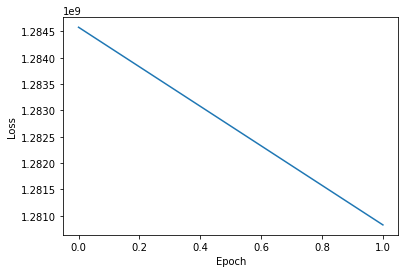

None


In [19]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
print(plt.show())

In [20]:
for img in glob.glob("*.png"):
    display(img)

'sample20.png'

'sample14.png'

'sample69.png'

'sample19.png'

'sample64.png'

'sample59.png'

'sample10.png'

'sample4.png'

'sample39.png'

'sample68.png'

'sample44.png'

'sample8.png'

'sample73.png'

'sample82.png'

'sample40.png'

'sample49.png'

'sample79.png'

'sample24.png'

'sample54.png'

'sample41.png'

'sample15.png'

'sample70.png'

'sample81.png'

'sample80.png'

'sample88.png'

'sample28.png'

'sample92.png'

'sample16.png'

'sample42.png'

'sample31.png'

'sample63.png'

'sample7.png'

'sample58.png'

'sample36.png'

'sample25.png'

'sample62.png'

'sample67.png'

'sample6.png'

'sample72.png'

'sample33.png'

'sample89.png'

'sample98.png'

'sample53.png'

'sample52.png'

'sample3.png'

'sample77.png'

'sample96.png'

'sample5.png'

'sample95.png'

'sample86.png'

'sample46.png'

'sample65.png'

'sample35.png'

'sample100.png'

'sample22.png'

'sample37.png'

'sample93.png'

'sample21.png'

'sample30.png'

'sample38.png'

'sample43.png'

'sample27.png'

'sample55.png'

'sample45.png'

'sample99.png'

'sample60.png'

'sample18.png'

'sample29.png'

'sample83.png'

'sample2.png'

'sample84.png'

'sample51.png'

'sample85.png'

'sample13.png'

'sample11.png'

'sample75.png'

'sample66.png'

'sample57.png'

'sample91.png'

'sample47.png'

'sample74.png'

'sample78.png'

'sample56.png'

'sample1.png'

'sample23.png'

'sample90.png'

'sample61.png'

'sample94.png'

'sample71.png'

'sample17.png'

'sample9.png'

'sample97.png'

'sample50.png'

'sample26.png'

'sample87.png'

'sample48.png'

'sample34.png'

'sample12.png'

'sample76.png'

'sample32.png'

Just this.<br>
<i>Thank you!</i>